In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/HAM10000.zip 

In [3]:
from dataloader import segmentation_dataset 
from models import UNetCompiled 
from matplotlib import pyplot as plt 
%matplotlib inline 

In [4]:
(X_train, y_train), (X_valid, y_valid) = segmentation_dataset('HAM10000') 

10015it [01:29, 111.55it/s]


In [5]:
model = UNetCompiled() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

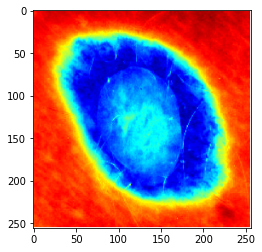

In [6]:
plt.imshow(X_train[5]) 
plt.show() 

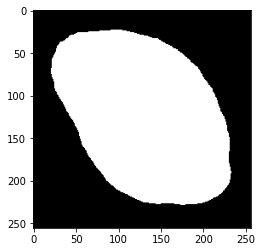

In [7]:
plt.imshow(y_train[5].reshape((256,256)), cmap='gray') 
plt.show() 

In [8]:
model = UNetCompiled() 


Epoch 1/30
251/251 [==============================] - ETA: 0s - loss: 0.4277 - Accuracy: 0.8709
Epoch 1: val_Accuracy improved from -inf to 0.91935, saving model to Unet_model.hdf5
251/251 [==============================] - 47s 136ms/step - loss: 0.4277 - Accuracy: 0.8709 - val_loss: 0.2241 - val_Accuracy: 0.9193 - lr: 0.0010
Epoch 2/30
250/251 [============================>.] - ETA: 0s - loss: 0.2214 - Accuracy: 0.9211
Epoch 2: val_Accuracy improved from 0.91935 to 0.92851, saving model to Unet_model.hdf5
251/251 [==============================] - 30s 119ms/step - loss: 0.2214 - Accuracy: 0.9211 - val_loss: 0.1963 - val_Accuracy: 0.9285 - lr: 0.0010
Epoch 3/30
250/251 [============================>.] - ETA: 0s - loss: 0.1965 - Accuracy: 0.9306
Epoch 3: val_Accuracy improved from 0.92851 to 0.93936, saving model to Unet_model.hdf5
251/251 [==============================] - 30s 119ms/step - loss: 0.1964 - Accuracy: 0.9306 - val_loss: 0.1669 - val_Accuracy: 0.9394 - lr: 0.0010
Epoch 4/30

In [10]:
from tensorflow.keras.models import load_model

model = load_model('Unet_model.hdf5') 

In [ ]:
!unzip /content/drive/MyDrive/SegClassify-colormap.zip 

In [14]:
del X_train, y_train, X_valid, y_valid 

In [13]:
import numpy as np, os, glob
from tqdm import tqdm
import cv2

imagesPath = os.path.join('SegClassify-colormap', '*') 
Images = glob.glob(imagesPath)

X = np.zeros((len(Images), 256, 256, 3), dtype=np.float32) 

for n, imagepath in tqdm(enumerate(Images)):
    img = cv2.imread(imagepath)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    X[n] = img


15803it [01:39, 158.16it/s]


In [15]:
BATCHSIZE = 128 
batches = int(len(X) / BATCHSIZE) 
Y = np.zeros((len(X), 256, 256, 1), dtype=np.bool_) 
print(batches) 

123


In [22]:
from skimage.filters import threshold_otsu

for b in range(batches):
 predictions = model.predict(X[b*BATCHSIZE:b*BATCHSIZE+BATCHSIZE,:]) 
 batch = np.zeros((len(predictions), 256, 256, 1), dtype=np.bool_) 
 for i, prediction in enumerate(predictions):
    thresh = threshold_otsu(prediction)
    batch[i,:] = prediction > thresh

 Y[b*BATCHSIZE:b*BATCHSIZE+BATCHSIZE,:] = batch 


4/4 [==============================] - 0s 38ms/step


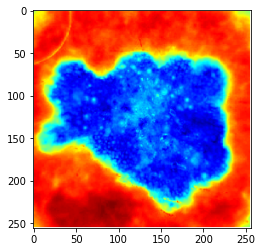

In [28]:
plt.imshow(X[7]) 

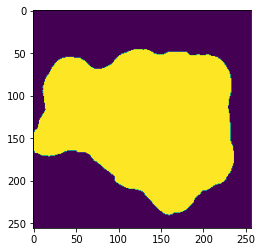

In [29]:
plt.imshow(Y[7].reshape((256,256))) 

In [25]:
def apply_mask(image, mask):
    mask = mask.astype("uint8")
    seg = cv2.bitwise_and(image, image, mask=mask)
    return seg 

In [26]:
def show_images(images):
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1) 
        plt.imshow(images[i])

    plt.show(block=True)

In [ ]:
for i in range(len(X)//3):
  masked = []
  for image, mask in zip(X[i*4:(i*4)+4], Y[i*4:(i*4)+4]):
    seg = apply_mask(image, mask)
    masked.append(seg) 
  show_images(masked)
  if i == 10:
    break

In [ ]:
from PIL import Image
from tqdm import tqdm

Images = os.listdir('SegClassify-colormap')
dest = os.path.join('drive', 'MyDrive', 'segPredictedMasks')
os.mkdir(dest)

for i, impath in tqdm(enumerate(Images)):
  im = Image.fromarray(Y[i].reshape((256, 256)))
  path = os.path.join(dest, '{}_segmentation.{}'.format(impath[:-4], 'png')) 
  im.save(path) 


In [ ]:
print(len(os.listdir(dest))) 

In [ ]:
import os, shutil
def make_archive(source, destination):
        base = os.path.basename(destination)
        name = base.split('.')[0]
        format = base.split('.')[1]
        archive_from = os.path.dirname(source)
        archive_to = os.path.basename(source.strip(os.sep))
        shutil.make_archive(name, format, archive_from, archive_to)
        shutil.move('%s.%s'%(name,format), destination) 

make_archive(dest, 'masks.zip') 